In [44]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [45]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Reshape, Bidirectional, LSTM
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

print( 'TensorFlow Version:', tf.__version__ )
print( 'Keras Version:', tf.keras.__version__ ) 

TensorFlow Version: 2.5.0
Keras Version: 2.5.0


In [54]:
# Path to the dataset directory
train = pd.read_csv('./dataset/label/public_training_data.csv')
valid = pd.read_csv('./dataset/label/public_validation_data.csv')

data_dir_train = Path('./dataset/non_modified/public_training_data/')
data_dir_valid = Path('./dataset/non_modified/public_validation_data/')
train['IMAGE'] = sorted(list(map(str, list(data_dir_train.glob('*.jpg')))))
valid['IMAGE'] = sorted(list(map(str, list(data_dir_valid.glob('*.jpg')))))

In [63]:
train.dropna(axis=0,inplace=True)
valid.dropna(axis=0,inplace=True)

train = train[train['label'] != 'UNREADABLE']
valid = valid[valid['label'] != 'UNREADABLE']

train.reset_index(inplace=True,drop=True)
valid.reset_index(inplace=True,drop=True)

train['label'] = train['label'].str.upper()
valid['label'] = valid['label'].str.upper()

train['Length']=train['label'].apply(lambda x : len(str(x)))
valid['Length']=valid['label'].apply(lambda x : len(str(x)))

train = train[train['Length']<=21]
valid = valid[valid['Length']<=21]

                               filename       label  \
0       oR72wdOuzdHVh3sMMmC4gMG2aG5jeub  3LN996012F   
1        7VVWhb6tKde=x=w5x6_p=lfcTlGTBa  2FV271041L   
2      VweTPTTYjERnFWFr3R7=YFKrj9NBT1Lg  2FV413012A   
3       XOIg4ZPERXLzBmsdMd4XNHYH1r=Urbr  3LP563013A   
4      jm85agd8RyzlDBl6jjnpypYIuVw7BTvb  3LR436033F   
...                                 ...         ...   
12062  KVbBuo6P=Pv4FsTMGW84LHFgiK2H2=nU  3LZ146042A   
12063  mVE9bWuj9S_vFwQHEIH_e5mMZ4javQF8  2G2204042K   
12064  glBWhEUeVftedEqw=qq=mzBrC=gwMyFs  2FM573063K   
12065  Xv19H4GQWajfdKTsHBcJoz8RaKTVa7BR   1WG43V203   
12066                            #NAME?  1W8935042F   

                                                   IMAGE  Length  
0      dataset\non_modified\public_training_data\11gU...      10  
1      dataset\non_modified\public_training_data\11vx...      10  
2      dataset\non_modified\public_training_data\12Mv...      10  
3      dataset\non_modified\public_training_data\12kv...      10  
4   

In [56]:
# Get list of all the images
Images = sorted( list(map(str, list(data_dir.glob('*.jpg')))) )
Labels = [ img.split(os.path.sep)[-1].split(".jpg")[0] for img in Images ]
Characters = set( char for label in Labels for char in label )
Image_Height = set( tf.image.decode_png(tf.io.read_file(img_path)).shape[0] for img_path in Images )
Image_Width = set( tf.image.decode_png(tf.io.read_file(img_path)).shape[1] for img_path in Images )

# Maximum length of any captcha in the dataset
Max_Length = max([ len(label) for label in Labels ])

print( 'Number of images found: ', len(Images) )
print( 'Number of labels found: ', len(Labels), '\n' )
print( 'Width of any captcha image:', next(iter(Image_Width)) )
print( 'Height of any captcha image:', next(iter(Image_Height)) )
print( 'Characters present: ', Characters ) 
print( 'Number of unique characters: ', len(Characters) )
print( 'Maxium length of any captcha image: ', Max_Length )

Number of images found:  12067
Number of labels found:  12067 

Width of any captcha image: 1232
Height of any captcha image: 1028
Characters present:  {'R', '3', 'G', 'h', 'M', '9', 'C', 'c', 'E', 'Z', 'S', '=', 'T', 'm', 'i', 'P', 's', '5', 'q', '4', 'D', 'Y', 't', 'Q', 'O', 'p', 'U', 'u', 'X', 'H', 'F', 'v', 'd', 'b', 'x', 'K', 'e', '6', '_', 'J', 'I', 'k', 'f', 'w', '7', 'V', '2', '1', 'a', '8', 'L', 'j', 'l', 'n', 'g', 'B', 'o', 'W', 'z', 'r', 'y', 'N'}
Number of unique characters:  62
Maxium length of any captcha image:  32


In [57]:
# Desired image dimensions where img_width % 4==0 and img_hight % 16==0 
img_width = 256
img_height = 64

# Number of passes of the entire training set the algorithm has completed
Epochs = 128

# Number of each batch
Batch_Size = 120

# Early Stopping
'''
min_delta: 容忍模型進步的最小幅度
patience: 容忍訓練無再進步時的 Epoch 次數
'''
Early_Stopping_Patience = 10 
Min_Delta = 0.0001

In [58]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
                  vocabulary=sorted(list(Characters)), num_oov_indices=0, mask_token=None )

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
                  vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True )

In [59]:
def encode_single_sample( img_path, label ):
    # 1. Read image
    img = tf.io.read_file( img_path )
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png( img, channels=1 )
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype( img, tf.float32 )
    # 4. Resize to the desired size
    img = tf.image.resize( img, [img_height,img_width] )
    # 5. Transpose the image because we want the time dimension to correspond to the width of the image, 
    #    i.e., shape = (img_weight,img_height,1).
    img = tf.transpose( img, perm=[1,0,2] )
    # 6. Map the characters in label to numbers
    label = char_to_num( tf.strings.unicode_split(label, input_encoding='UTF-8') )
    # 7. Return a dict as our model is expecting two inputs
    return { "Input": img, "Label": label }

In [60]:
# Splitting dataset into training and validation sets
def split_data( Images, Labels, train_size=0.9, shuffle=True ):
    # 1. Get the total amount of the dataset
    size = len( Images )
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange( size )
    if shuffle:
        np.random.seed(42) 
        np.random.shuffle( indices )
    # 3. Get the size of training samples
    train_samples = int( size*train_size )
    # 4. Split data into training and validation sets
    x_train, y_train = Images[indices[:train_samples]], Labels[indices[:train_samples]]
    x_valid, y_valid = Images[indices[train_samples:]], Labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

x_train, x_valid, y_train, y_valid = split_data( np.array(Images), np.array(Labels) )

print( 'Number of training set:', len(x_train) )
print( 'Number of validation set:', len(x_valid) )

Number of training set: 10860
Number of validation set: 1207


In [61]:
# Create training and valodation dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices( (x_train,y_train) )
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(Batch_Size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices( (x_valid,y_valid) )
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(Batch_Size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

InvalidArgumentError: Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [30], [batch]: [31] [Op:IteratorGetNext]

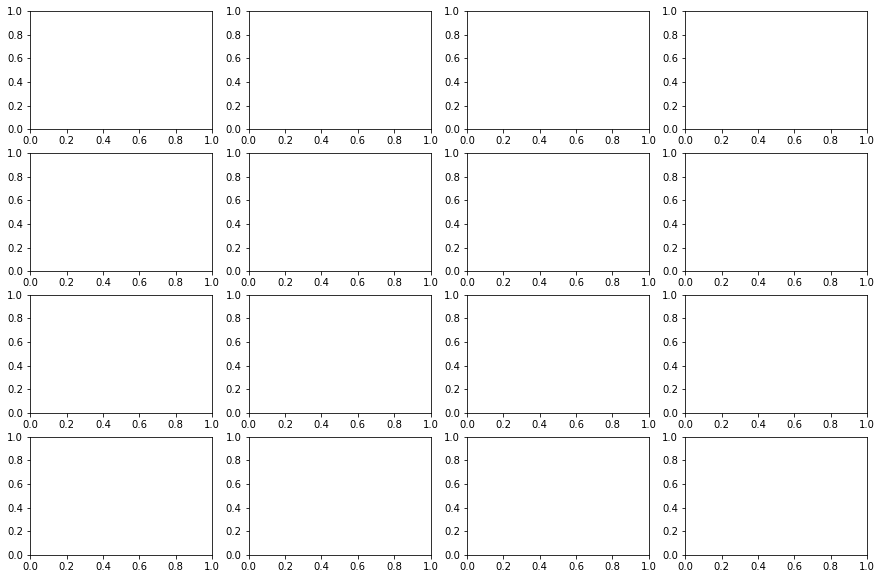

In [62]:
# Visualize the Training Dataset
_, ax = plt.subplots(4, 4, figsize=(15, 10))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [25]:
# Build an endpoint layer for implementing CTC loss.
class CTCLayer( layers.Layer ):
    def __init__( self, name=None, **kwargs ):
        super().__init__( name=name )
        self.loss_fn = K.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it to the layer using `self.add_loss()`.
        batch_len = tf.cast( tf.shape(y_true)[0], dtype='int64' )
        input_length = tf.cast( tf.shape(y_pred)[1], dtype='int64' )
        label_length = tf.cast( tf.shape(y_true)[1], dtype='int64' )
        
        input_length = input_length*tf.ones( shape=(batch_len,1), dtype='int64' )
        label_length = label_length*tf.ones( shape=(batch_len,1), dtype='int64' )

        loss = self.loss_fn( y_true, y_pred, input_length, label_length )
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [26]:
def Build_Model():
    # Inputs to the model 
    input_tensor = Input( (img_width,img_height,1), dtype='float32', name='Input' )
    labels = Input( shape=(None,), dtype='float32', name="Label" )
    
    # First convolution block
    x = Conv2D( 64, (3,3), activation='relu', padding='same', name='Conv_1' )(input_tensor)
    x = MaxPooling2D( pool_size=(2,2), strides=2, name='MaxPooling_1' )(x)
    
    # Second convolution block
    x = Conv2D( 128, (3,3), activation='relu', padding='same', name='Conv_2' )(x)
    x = MaxPooling2D( pool_size=(2,2), strides=2, name='MaxPooling_2' )(x)
    
    # Third convolution block
    x = Conv2D( 256, (3,3), activation='relu', padding='same', name='Conv_3' )(x)
    x = BatchNormalization( name='BN_1' )(x)
    
    # Fourth convolution block
    x = Conv2D( 512, (3,3), activation='relu', padding='same', name='Conv_4' )(x)  
    x = MaxPooling2D( pool_size=(2,1), strides=2, name='MaxPooling_3' )(x)
    
    # Fifth convolution block
    x = Conv2D( 512, (2,2), activation='relu', name='Conv_5' )(x)
    
    # Reshape accordingly before passing the output to the RNN part of the model,
    # i.e., convert shape=(batch,feature_weight,feature_height,channel) to shape=(batch,feature_weight,channel*feature_height) 
    Conv_Shape = x.get_shape( )
    x = Reshape( target_shape=(int(Conv_Shape[1]),int(Conv_Shape[2]*Conv_Shape[3])), name='Reshape' )(x)
    x = Dense( 64, activation='relu', name='Dense' )(x)
    x = Dropout( 0.25, name='Dropout' )(x)

    # RNNs
    x = Bidirectional( LSTM( 256, return_sequences=True, dropout=0.25 ), name='LSTM_1' )(x)
    x = Bidirectional( LSTM( 256, return_sequences=True, dropout=0.25 ), name='LSTM_2' )(x)

    # Output layer
    x = Dense( len(Characters)+1, activation='softmax', name='Softmax' )(x) 

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer( name='CTC_Loss' )(labels, x)
    
    # Define the model
    model = Model( inputs=[input_tensor,labels], outputs=[output], name='CRNN_Model_with_CTC_LOSS' )    
    
    # Compile the model and return
    model.compile( optimizer=Adam() )
    
    return model

CRNN = Build_Model()
CRNN.summary()

Model: "CRNN_Model_with_CTC_LOSS"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 250, 550, 1) 0                                            
__________________________________________________________________________________________________
Conv_1 (Conv2D)                 (None, 250, 550, 64) 640         Input[0][0]                      
__________________________________________________________________________________________________
MaxPooling_1 (MaxPooling2D)     (None, 125, 275, 64) 0           Conv_1[0][0]                     
__________________________________________________________________________________________________
Conv_2 (Conv2D)                 (None, 125, 275, 128 73856       MaxPooling_1[0][0]               
___________________________________________________________________________

In [27]:
# Model Check Point
Check_Point = ModelCheckpoint( 'CRNN.h5',   # Filepath
                               monitor='val_loss',
                               save_best_only=True,
                               verbose=1,
                               mode='auto',
                               save_weights_only=False,
                               save_freq='epoch' )

In [28]:
# Add early stopping
Early_Stopping = EarlyStopping( monitor='val_loss',
                                min_delta=Min_Delta,
                                patience=Early_Stopping_Patience,
                                verbose=1,
                                mode='auto',
                                baseline=None,
                                restore_best_weights=True )

In [29]:
History = CRNN.fit( train_dataset, validation_data=validation_dataset, epochs=Epochs, 
                    callbacks=[ Check_Point, Early_Stopping ] )     

Epoch 1/100


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [30], [batch]: [32]
	 [[node IteratorGetNext (defined at <ipython-input-29-bb4eac9e3457>:1) ]]
  (1) Invalid argument:  Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [30], [batch]: [32]
	 [[node IteratorGetNext (defined at <ipython-input-29-bb4eac9e3457>:1) ]]
	 [[IteratorGetNext/_7]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_85178]

Function call stack:
train_function -> train_function
